In [70]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card
Датасет по невыплате кредитов.

Задача: построение моделей, **анализ и визуализация влияния признаков на целевую переменную** в целом и по отдельным клиентам при помощи библиотеки SHAP (SHapley Additive exPlanations).

**1. Изучаем датасет по невыплате по кредитам**

In [71]:
data = pd.read_excel('/Users/Alisa/Downloads/default of credit card clients.xls', index_col = 'Unnamed: 0')

In [72]:
data.head(7)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
6,50000,1,1,2,37,0,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0


In [73]:
data.shape

(30001, 24)

In [74]:
data['Y'].value_counts() #есть дисбаланс классов

0                             23364
1                              6636
default payment next month        1
Name: Y, dtype: int64

In [75]:
df = data.rename(columns=data.iloc[0]).drop(data.index[0]) #уберем лишнюю строку в шапке

Избавимся от дисбаланса классов, удалив часть данных

In [76]:
df_0 = df.loc[df['default payment next month'] == 0]

In [77]:
df_0 = df_0.sample(6636)

In [78]:
df_1 = df.loc[df['default payment next month'] == 1]

In [79]:
frames = [df_0, df_1]
df = pd.concat(frames)
df = df.sample(frac = 1)

In [80]:
df.dtypes #посмотрим, какие типы данных 

LIMIT_BAL                     object
SEX                           object
EDUCATION                     object
MARRIAGE                      object
AGE                           object
PAY_0                         object
PAY_2                         object
PAY_3                         object
PAY_4                         object
PAY_5                         object
PAY_6                         object
BILL_AMT1                     object
BILL_AMT2                     object
BILL_AMT3                     object
BILL_AMT4                     object
BILL_AMT5                     object
BILL_AMT6                     object
PAY_AMT1                      object
PAY_AMT2                      object
PAY_AMT3                      object
PAY_AMT4                      object
PAY_AMT5                      object
PAY_AMT6                      object
default payment next month    object
dtype: object

In [81]:
df = df.apply(pd.to_numeric) #приведем к числовому типу

In [83]:
df.describe() #посмотрим на статистику выборки

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,13272.000000,13272.000000,13272.000000,13272.000000,13272.000000,13272.000000,13272.000000,13272.000000,13272.000000,13272.000000,...,13272.000000,13272.000000,13272.000000,13272.000000,1.327200e+04,13272.000000,13272.000000,13272.000000,13272.000000,13272.000000
mean,153886.202532,1.591621,1.867767,1.545660,35.626281,0.224005,0.080244,0.016652,-0.056962,-0.110533,...,42275.644439,39468.481314,38088.425934,4791.606465,5.065382e+03,4501.665838,4235.002939,4262.529837,4503.300482,0.500000
std,126181.292989,0.491552,0.772665,0.523887,9.400893,1.261912,1.343710,1.338141,1.319816,1.287795,...,63281.292752,59721.111572,58611.854631,14313.395416,2.360597e+04,14343.494530,14133.068160,14698.983810,16055.288337,0.500019
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-53007.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2302.500000,1673.500000,1221.750000,390.000000,3.900000e+02,193.000000,21.750000,1.000000,0.000000,0.000000
50%,120000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,18982.000000,18185.500000,17299.000000,2000.000000,2.000000e+03,1544.000000,1237.500000,1300.000000,1200.000000,0.500000
75%,220000.000000,2.000000,2.000000,2.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,51886.250000,48809.500000,48037.000000,4520.750000,4.267250e+03,4000.000000,3588.250000,3623.000000,3501.000000,1.000000
max,800000.000000,2.000000,6.000000,3.000000,75.000000,8.000000,7.000000,8.000000,8.000000,8.000000,...,628699.000000,547880.000000,699944.000000,493358.000000,1.684259e+06,508229.000000,528897.000000,417990.000000,403500.000000,1.000000


In [84]:
df_is_null = pd.isnull(df) 

In [85]:
df_is_null.info() #проверим пропуски

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13272 entries, 27915 to 2737
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   13272 non-null  bool 
 1   SEX                         13272 non-null  bool 
 2   EDUCATION                   13272 non-null  bool 
 3   MARRIAGE                    13272 non-null  bool 
 4   AGE                         13272 non-null  bool 
 5   PAY_0                       13272 non-null  bool 
 6   PAY_2                       13272 non-null  bool 
 7   PAY_3                       13272 non-null  bool 
 8   PAY_4                       13272 non-null  bool 
 9   PAY_5                       13272 non-null  bool 
 10  PAY_6                       13272 non-null  bool 
 11  BILL_AMT1                   13272 non-null  bool 
 12  BILL_AMT2                   13272 non-null  bool 
 13  BILL_AMT3                   13272 non-null  bool 
 14  BIL

In [86]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='default payment next month'), 
                                                    df['default payment next month'], random_state=1)

**2. Протестируем несколько моделей** для бинарной классификации. Это модели, представляющие собой ансамбли "деревьев", использующие градиентный бустинг. Данные модели не требуют масштабирования данных.

XGBoost

In [87]:
import xgboost as xgb
from xgboost import XGBClassifier

xgb_classifier = XGBClassifier()

xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [88]:
predictions =  xgb_classifier.predict(X_test)

In [89]:
precision, recall, thresholds = precision_recall_curve(y_test, predictions)
f_score = (2 * precision * recall) / (precision + recall)                              

In [90]:
ix = np.argmax(f_score)
print(f'Best Threshold={thresholds[ix]}, F-Score={f_score[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=1, F-Score=0.670, Precision=0.711, Recall=0.635


LightGBM

In [94]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [97]:
from lightgbm import LGBMClassifier
lgb_classifier = LGBMClassifier()
lgb_classifier.fit(X_train, y_train)

predictions = lgb_classifier.predict(X_test)

In [98]:
precision, recall, thresholds = precision_recall_curve(y_test, predictions)
f_score = (2 * precision * recall) / (precision + recall)     

In [99]:
ix = np.argmax(f_score)
print(f'Best Threshold={thresholds[ix]}, F-Score={f_score[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=1, F-Score=0.675, Precision=0.739, Recall=0.621


Модель **CatBoost**

In [100]:
from catboost import CatBoostClassifier
cat_classifier = CatBoostClassifier()

In [101]:
cat_classifier.fit(X_train, y_train)

predictions = cat_classifier.predict(X_test)

Learning rate set to 0.027484
0:	learn: 0.6856370	total: 184ms	remaining: 3m 3s
1:	learn: 0.6785056	total: 191ms	remaining: 1m 35s
2:	learn: 0.6717980	total: 199ms	remaining: 1m 5s
3:	learn: 0.6658851	total: 205ms	remaining: 51.1s
4:	learn: 0.6607537	total: 212ms	remaining: 42.1s
5:	learn: 0.6552675	total: 219ms	remaining: 36.2s
6:	learn: 0.6499935	total: 225ms	remaining: 32s
7:	learn: 0.6455186	total: 232ms	remaining: 28.8s
8:	learn: 0.6406724	total: 239ms	remaining: 26.3s
9:	learn: 0.6365909	total: 245ms	remaining: 24.2s
10:	learn: 0.6324619	total: 251ms	remaining: 22.6s
11:	learn: 0.6286327	total: 257ms	remaining: 21.2s
12:	learn: 0.6251311	total: 263ms	remaining: 20s
13:	learn: 0.6212257	total: 269ms	remaining: 18.9s
14:	learn: 0.6178457	total: 274ms	remaining: 18s
15:	learn: 0.6151570	total: 280ms	remaining: 17.2s
16:	learn: 0.6122608	total: 286ms	remaining: 16.5s
17:	learn: 0.6092863	total: 292ms	remaining: 15.9s
18:	learn: 0.6064669	total: 298ms	remaining: 15.4s
19:	learn: 0.603

174:	learn: 0.5304030	total: 1.29s	remaining: 6.07s
175:	learn: 0.5303024	total: 1.29s	remaining: 6.06s
176:	learn: 0.5301774	total: 1.3s	remaining: 6.06s
177:	learn: 0.5300852	total: 1.31s	remaining: 6.05s
178:	learn: 0.5299483	total: 1.31s	remaining: 6.04s
179:	learn: 0.5298318	total: 1.32s	remaining: 6.02s
180:	learn: 0.5297104	total: 1.33s	remaining: 6.01s
181:	learn: 0.5295395	total: 1.33s	remaining: 6s
182:	learn: 0.5293954	total: 1.34s	remaining: 5.98s
183:	learn: 0.5292103	total: 1.35s	remaining: 5.97s
184:	learn: 0.5289811	total: 1.35s	remaining: 5.96s
185:	learn: 0.5288606	total: 1.36s	remaining: 5.95s
186:	learn: 0.5287769	total: 1.36s	remaining: 5.94s
187:	learn: 0.5286013	total: 1.37s	remaining: 5.92s
188:	learn: 0.5284629	total: 1.38s	remaining: 5.91s
189:	learn: 0.5282462	total: 1.38s	remaining: 5.9s
190:	learn: 0.5280913	total: 1.39s	remaining: 5.89s
191:	learn: 0.5279552	total: 1.4s	remaining: 5.88s
192:	learn: 0.5278605	total: 1.4s	remaining: 5.86s
193:	learn: 0.52773

344:	learn: 0.5081624	total: 2.38s	remaining: 4.52s
345:	learn: 0.5080832	total: 2.39s	remaining: 4.51s
346:	learn: 0.5079069	total: 2.4s	remaining: 4.51s
347:	learn: 0.5078262	total: 2.4s	remaining: 4.5s
348:	learn: 0.5076586	total: 2.41s	remaining: 4.49s
349:	learn: 0.5075348	total: 2.41s	remaining: 4.48s
350:	learn: 0.5074273	total: 2.42s	remaining: 4.47s
351:	learn: 0.5073155	total: 2.42s	remaining: 4.46s
352:	learn: 0.5071258	total: 2.43s	remaining: 4.46s
353:	learn: 0.5069786	total: 2.44s	remaining: 4.45s
354:	learn: 0.5068785	total: 2.44s	remaining: 4.44s
355:	learn: 0.5067792	total: 2.45s	remaining: 4.43s
356:	learn: 0.5066020	total: 2.46s	remaining: 4.42s
357:	learn: 0.5064514	total: 2.46s	remaining: 4.42s
358:	learn: 0.5062972	total: 2.47s	remaining: 4.41s
359:	learn: 0.5061969	total: 2.48s	remaining: 4.4s
360:	learn: 0.5060007	total: 2.48s	remaining: 4.39s
361:	learn: 0.5058309	total: 2.49s	remaining: 4.38s
362:	learn: 0.5056417	total: 2.49s	remaining: 4.38s
363:	learn: 0.50

522:	learn: 0.4822037	total: 3.49s	remaining: 3.18s
523:	learn: 0.4821105	total: 3.5s	remaining: 3.18s
524:	learn: 0.4819707	total: 3.5s	remaining: 3.17s
525:	learn: 0.4819335	total: 3.51s	remaining: 3.16s
526:	learn: 0.4818845	total: 3.52s	remaining: 3.16s
527:	learn: 0.4818149	total: 3.52s	remaining: 3.15s
528:	learn: 0.4816903	total: 3.53s	remaining: 3.14s
529:	learn: 0.4814931	total: 3.54s	remaining: 3.13s
530:	learn: 0.4813862	total: 3.54s	remaining: 3.13s
531:	learn: 0.4812275	total: 3.55s	remaining: 3.12s
532:	learn: 0.4810779	total: 3.55s	remaining: 3.11s
533:	learn: 0.4808796	total: 3.56s	remaining: 3.11s
534:	learn: 0.4807142	total: 3.56s	remaining: 3.1s
535:	learn: 0.4805777	total: 3.57s	remaining: 3.09s
536:	learn: 0.4804628	total: 3.58s	remaining: 3.08s
537:	learn: 0.4803809	total: 3.58s	remaining: 3.08s
538:	learn: 0.4801791	total: 3.59s	remaining: 3.07s
539:	learn: 0.4800862	total: 3.59s	remaining: 3.06s
540:	learn: 0.4799898	total: 3.6s	remaining: 3.06s
541:	learn: 0.47

694:	learn: 0.4597838	total: 4.6s	remaining: 2.02s
695:	learn: 0.4596774	total: 4.61s	remaining: 2.01s
696:	learn: 0.4595378	total: 4.62s	remaining: 2.01s
697:	learn: 0.4594004	total: 4.62s	remaining: 2s
698:	learn: 0.4593397	total: 4.63s	remaining: 1.99s
699:	learn: 0.4592254	total: 4.64s	remaining: 1.99s
700:	learn: 0.4591459	total: 4.64s	remaining: 1.98s
701:	learn: 0.4590499	total: 4.65s	remaining: 1.97s
702:	learn: 0.4589412	total: 4.66s	remaining: 1.97s
703:	learn: 0.4587975	total: 4.66s	remaining: 1.96s
704:	learn: 0.4586491	total: 4.67s	remaining: 1.95s
705:	learn: 0.4585551	total: 4.67s	remaining: 1.95s
706:	learn: 0.4583784	total: 4.68s	remaining: 1.94s
707:	learn: 0.4582341	total: 4.68s	remaining: 1.93s
708:	learn: 0.4580928	total: 4.69s	remaining: 1.93s
709:	learn: 0.4579889	total: 4.7s	remaining: 1.92s
710:	learn: 0.4578505	total: 4.7s	remaining: 1.91s
711:	learn: 0.4576912	total: 4.71s	remaining: 1.9s
712:	learn: 0.4575787	total: 4.71s	remaining: 1.9s
713:	learn: 0.457417

868:	learn: 0.4402337	total: 5.7s	remaining: 859ms
869:	learn: 0.4401484	total: 5.7s	remaining: 852ms
870:	learn: 0.4400954	total: 5.71s	remaining: 846ms
871:	learn: 0.4399812	total: 5.72s	remaining: 839ms
872:	learn: 0.4398930	total: 5.72s	remaining: 832ms
873:	learn: 0.4397908	total: 5.73s	remaining: 826ms
874:	learn: 0.4396915	total: 5.74s	remaining: 819ms
875:	learn: 0.4395575	total: 5.74s	remaining: 813ms
876:	learn: 0.4394948	total: 5.75s	remaining: 806ms
877:	learn: 0.4393703	total: 5.75s	remaining: 799ms
878:	learn: 0.4392710	total: 5.76s	remaining: 793ms
879:	learn: 0.4391450	total: 5.77s	remaining: 786ms
880:	learn: 0.4390515	total: 5.77s	remaining: 780ms
881:	learn: 0.4389443	total: 5.78s	remaining: 773ms
882:	learn: 0.4388528	total: 5.78s	remaining: 766ms
883:	learn: 0.4387122	total: 5.79s	remaining: 760ms
884:	learn: 0.4386225	total: 5.79s	remaining: 753ms
885:	learn: 0.4385104	total: 5.8s	remaining: 746ms
886:	learn: 0.4384292	total: 5.81s	remaining: 740ms
887:	learn: 0.4

In [102]:
precision, recall, thresholds = precision_recall_curve(y_test, predictions)
f_score = (2 * precision * recall) / (precision + recall)   

In [103]:
ix = np.argmax(f_score)
print(f'Best Threshold={thresholds[ix]}, F-Score={f_score[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=1, F-Score=0.681, Precision=0.749, Recall=0.624


Выбор модели зависит от того, какую метрику нужно максимизировать. В данном случае нужно максимально выявить тех клиентов, которые не выплатят долги. Наиболее важной метрикой будет, вероятно, recall, в таком случае подходящей моделью - XGBoost

**4. Работа с SHAP** (SHapley Additive exPlanations): определение вклада признаков в процесс, определяющий целевую переменную, по формуле Шепли

In [244]:
!pip install shap

In [104]:
import shap

shap.initjs()

In [105]:
explainer_xgb = shap.Explainer(xgb_classifier)
shap_values_xgb = explainer_xgb.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


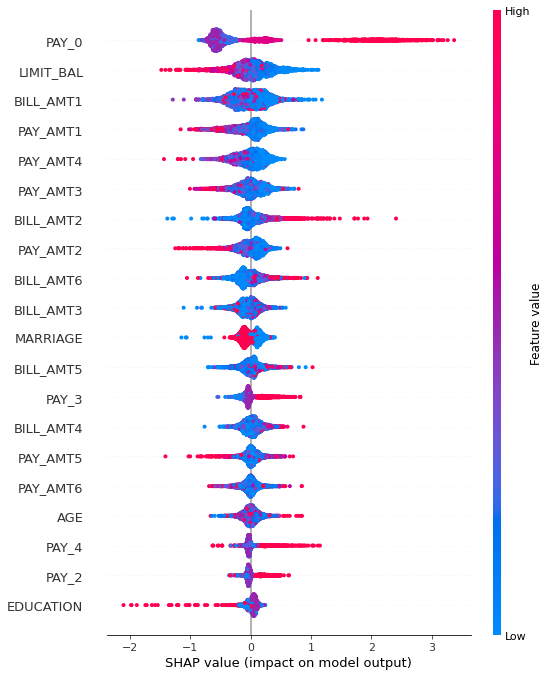

In [106]:
shap.summary_plot(shap_values_xgb, X_test)

**Для сравнения применим SHAP и к моделям CatBoost и LightGBM**

In [116]:
explainer_cat = shap.Explainer(cat_classifier)
shap_values_cat = explainer_cat.shap_values(X_test)

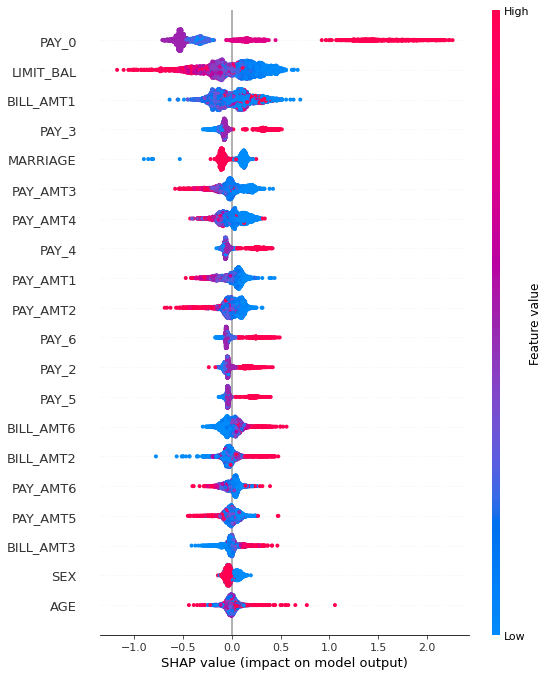

In [117]:
shap.summary_plot(shap_values_cat, X_test)

In [120]:
explainer_lgb = shap.Explainer(lgb_classifier)
shap_values_lgb = explainer_lgb.shap_values(X_test)[1]

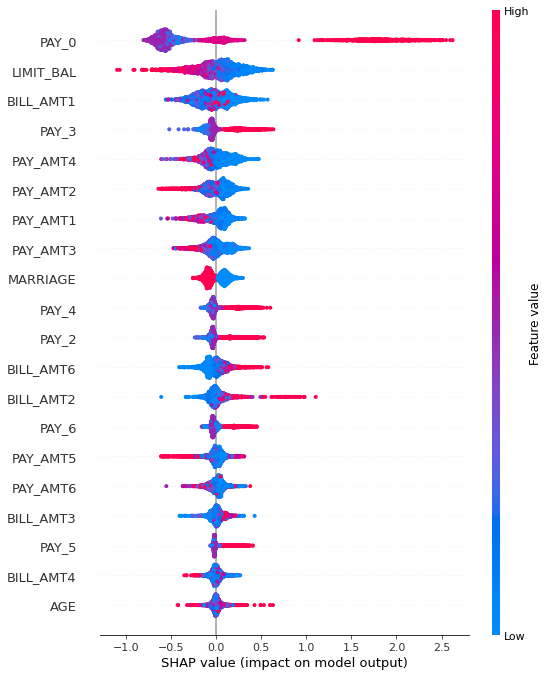

In [121]:
shap.summary_plot(shap_values_lgb, X_test)

Диаграммы, визуализирующие влияния признаков на целевую переменную, получились похожими для всех трех моделей, что свидетельствует в пользу их достоверности.

**5. Интерпретация резльтатов**

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. 
This study reviewed the literature and used the following 23 variables as explanatory variables:

X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.

X2: Gender (1 = male; 2 = female).

X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).

X4: Marital status (1 = married; 2 = single; 3 = others).

X5: Age (year).

X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.

X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.

X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.

In [286]:
data.head(5)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0


**Выделим самые важные факторы, предсказывающих вероятность невыплаты клиентом платежей банку**

**PAY_O**. Это информация по осуществлению платежей клиентом за сентябрь (т.е. по состоянию на сентябрь), самый недавний месяц (в датасете сравнивали данные за 6 месяцев 2005 г.: апрель - сентябрь). Большие значения показывают, что клиент на данный момент задерживает платежи по своему кредиту на несколько месяцев (указывается фактически количество месяцев просрочки). 

Т.е. неплательщики (на данный момент времени), задерживающие выплаты на несколько месяцев, с большей вероятностью не выплатят деньги и в следующий месяц. 

**PAY_2, PAY_3, PAY_4, PAY_5, PAY_6**. Аналогичны PAY_O, но отражает просрочки по выплатам в предшествующих месяцах.

**LIMIT_BAL** Показывает, какой кредит выдан клиенту. Тут выявляется закономерность: чем больше кредит, тем меньше вероятность просрочки. Вероятно, большие кредиты выдавались проверенным аккуратным клиентам.

**PAY_AMT1, PAY_AMT2, PAY_AMT3** - размер выплат, сделанных клиентом в предшествующие месяцы: чем он больше, тем меньше вероятности невыплаты. 

**EDUCATION**. Чем выше показатель образования, т.е. чем лучше образование, тем меньше вероятность просрочек. 

**Диаграммы для отдельного пользователя**

In [139]:
idx = 3
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[idx,:], X_train.iloc[idx,:])

In [140]:
idx = 3
shap.force_plot(explainer_cat.expected_value, shap_values_cat[idx,:], X_train.iloc[idx,:])

In [141]:
idx = 3
shap.force_plot(explainer_lgb.expected_value[1], shap_values_lgb[idx,:], X_train.iloc[idx,:])

В данном случае аккуратные платежи, осуществленные клиентом банка ранее, говорят в пользу своевременных выплат по обязательствам. 